In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 5GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/fetal-health-classification/fetal_health.csv


In [5]:
import seaborn as sb
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
import sklearn.metrics
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import plot_confusion_matrix
from sklearn.preprocessing import label_binarize
from sklearn.multiclass import OneVsRestClassifier
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import roc_auc_score
from scipy import interp
from itertools import cycle
from yellowbrick.classifier import ConfusionMatrix
from yellowbrick.classifier import ClassificationReport
from yellowbrick.classifier import ROCAUC
from yellowbrick.classifier import DiscriminationThreshold
from yellowbrick.classifier import PrecisionRecallCurve
import warnings

In [6]:
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=DeprecationWarning)

In [2]:
data = pd.read_csv('/kaggle/input/fetal-health-classification/fetal_health.csv')
data.head()

,baseline value,accelerations,fetal_movement,uterine_contractions,light_decelerations,severe_decelerations,prolongued_decelerations,abnormal_short_term_variability,mean_value_of_short_term_variability,percentage_of_time_with_abnormal_long_term_variability,...,histogram_min,histogram_max,histogram_number_of_peaks,histogram_number_of_zeroes,histogram_mode,histogram_mean,histogram_median,histogram_variance,histogram_tendency,fetal_health
0,120.0,0.000,0.0,0.000,0.000,0.0,0.0,73.0,0.5,43.0,...,62.0,126.0,2.0,0.0,120.0,137.0,121.0,73.0,1.0,2.0
1,132.0,0.006,0.0,0.006,0.003,0.0,0.0,17.0,2.1,0.0,...,68.0,198.0,6.0,1.0,141.0,136.0,140.0,12.0,0.0,1.0
2,133.0,0.003,0.0,0.008,0.003,0.0,0.0,16.0,2.1,0.0,...,68.0,198.0,5.0,1.0,141.0,135.0,138.0,13.0,0.0,1.0
3,134.0,0.003,0.0,0.008,0.003,0.0,0.0,16.0,2.4,0.0,...,53.0,170.0,11.0,0.0,137.0,134.0,137.0,13.0,1.0,1.0
4,132.0,0.007,0.0,0.008,0.000,0.0,0.0,16.0,2.4,0.0,...,53.0,170.0,9.0,0.0,137.0,136.0,138.0,11.0,1.0,1.0


In [7]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2126 entries, 0 to 2125
Data columns (total 22 columns):
 #   Column                                                  Non-Null Count  Dtype  
---  ------                                                  --------------  -----  
 0   baseline value                                          2126 non-null   float64
 1   accelerations                                           2126 non-null   float64
 2   fetal_movement                                          2126 non-null   float64
 3   uterine_contractions                                    2126 non-null   float64
 4   light_decelerations                                     2126 non-null   float64
 5   severe_decelerations                                    2126 non-null   float64
 6   prolongued_decelerations                                2126 non-null   float64
 7   abnormal_short_term_variability                         2126 non-null   float64
 8   mean_value_of_short_term_variability  

For better understanding of variables please refer to [this link](http://oacapps.med.jhmi.edu/OBGYN-101/Text/Labor%20and%20Delivery/electronic_fetal_heart_monitorin.htm)

* LB - FHR baseline (beats per minute)
* AC - # of accelerations per second
* FM - # of fetal movements per second
* UC - # of uterine contractions per second
* DL - # of light decelerations per second
* DS - # of severe decelerations per second
* DP - # of prolongued decelerations per second
* ASTV - percentage of time with abnormal short term variability
* MSTV - mean value of short term variability
* ALTV - percentage of time with abnormal long term variability
* MLTV - mean value of long term variability
* Width - width of FHR histogram
* Min - minimum of FHR histogram
* Max - Maximum of FHR histogram
* Nmax - # of histogram peaks
* Nzeros - # of histogram zeros
* Mode - histogram mode
* Mean - histogram mean
* Median - histogram median
* Variance - histogram variance
* Tendency - histogram tendency

* Class - fetal state class code (N= Normal ; S= Suspect ; P= Pathologic )

In [8]:
#rename columns
data.columns = ['FHR', 'AC', 'FM', 'UC', 'DL', 'DS', 'DP', 'ASTV', 'MSTV',
               'ALTV', 'MLTV', 'Width', 'Min', 'Max', 'NMax', 'Nzeros', 
                'Mode', 'Mean', 'Median', 'Variance', 'Tendency', 'Class']

In [9]:
data.columns

Index(['FHR', 'AC', 'FM', 'UC', 'DL', 'DS', 'DP', 'ASTV', 'MSTV', 'ALTV',
       'MLTV', 'Width', 'Min', 'Max', 'NMax', 'Nzeros', 'Mode', 'Mean',
       'Median', 'Variance', 'Tendency', 'Class'],
      dtype='object')

In [10]:
#convert target class to Int

data.Class = data.Class.astype('int')

In [11]:
label_encoder = preprocessing.LabelEncoder()

y_en = label_encoder.fit_transform(data.Class)

In [12]:
data = data.drop(['Class'], axis = 1)
data.head()

,FHR,AC,FM,UC,DL,DS,DP,ASTV,MSTV,ALTV,...,Width,Min,Max,NMax,Nzeros,Mode,Mean,Median,Variance,Tendency
0,120.0,0.000,0.0,0.000,0.000,0.0,0.0,73.0,0.5,43.0,...,64.0,62.0,126.0,2.0,0.0,120.0,137.0,121.0,73.0,1.0
1,132.0,0.006,0.0,0.006,0.003,0.0,0.0,17.0,2.1,0.0,...,130.0,68.0,198.0,6.0,1.0,141.0,136.0,140.0,12.0,0.0
2,133.0,0.003,0.0,0.008,0.003,0.0,0.0,16.0,2.1,0.0,...,130.0,68.0,198.0,5.0,1.0,141.0,135.0,138.0,13.0,0.0
3,134.0,0.003,0.0,0.008,0.003,0.0,0.0,16.0,2.4,0.0,...,117.0,53.0,170.0,11.0,0.0,137.0,134.0,137.0,13.0,1.0
4,132.0,0.007,0.0,0.008,0.000,0.0,0.0,16.0,2.4,0.0,...,117.0,53.0,170.0,9.0,0.0,137.0,136.0,138.0,11.0,1.0


In [13]:
#0-Normal
#1-Suspect
#2-Pathologic

y_en

array([1, 0, 0, ..., 1, 1, 0])

In [14]:
#AC - # of accelerations per second
#FM - # of fetal movements per second
#UC - # of uterine contractions per second
#DL - # of light decelerations per second
#DS - # of severe decelerations per second
#DP - # of prolongued decelerations per second

#All the variables are measured per second and has very low values, this cause scaling issues in our models. 
#So we convert them into per min, as FHR is also  measured per min.

clms = ['AC', 'FM', 'UC', 'DL', 'DS', 'DP']

for column in clms:
    data[column] = data[column]*60
    
data.head(10)

,FHR,AC,FM,UC,DL,DS,DP,ASTV,MSTV,ALTV,...,Width,Min,Max,NMax,Nzeros,Mode,Mean,Median,Variance,Tendency
0,120.0,0.00,0.0,0.00,0.00,0.0,0.00,73.0,0.5,43.0,...,64.0,62.0,126.0,2.0,0.0,120.0,137.0,121.0,73.0,1.0
1,132.0,0.36,0.0,0.36,0.18,0.0,0.00,17.0,2.1,0.0,...,130.0,68.0,198.0,6.0,1.0,141.0,136.0,140.0,12.0,0.0
2,133.0,0.18,0.0,0.48,0.18,0.0,0.00,16.0,2.1,0.0,...,130.0,68.0,198.0,5.0,1.0,141.0,135.0,138.0,13.0,0.0
3,134.0,0.18,0.0,0.48,0.18,0.0,0.00,16.0,2.4,0.0,...,117.0,53.0,170.0,11.0,0.0,137.0,134.0,137.0,13.0,1.0
4,132.0,0.42,0.0,0.48,0.00,0.0,0.00,16.0,2.4,0.0,...,117.0,53.0,170.0,9.0,0.0,137.0,136.0,138.0,11.0,1.0
5,134.0,0.06,0.0,0.60,0.54,0.0,0.12,26.0,5.9,0.0,...,150.0,50.0,200.0,5.0,3.0,76.0,107.0,107.0,170.0,0.0
6,134.0,0.06,0.0,0.78,0.48,0.0,0.18,29.0,6.3,0.0,...,150.0,50.0,200.0,6.0,3.0,71.0,107.0,106.0,215.0,0.0
7,122.0,0.00,0.0,0.00,0.00,0.0,0.00,83.0,0.5,6.0,...,68.0,62.0,130.0,0.0,0.0,122.0,122.0,123.0,3.0,1.0
8,122.0,0.00,0.0,0.12,0.00,0.0,0.00,84.0,0.5,5.0,...,68.0,62.0,130.0,0.0,0.0,122.0,122.0,123.0,3.0,1.0
9,122.0,0.00,0.0,0.18,0.00,0.0,0.00,86.0,0.3,6.0,...,68.0,62.0,130.0,1.0,0.0,122.0,122.0,123.0,1.0,1.0


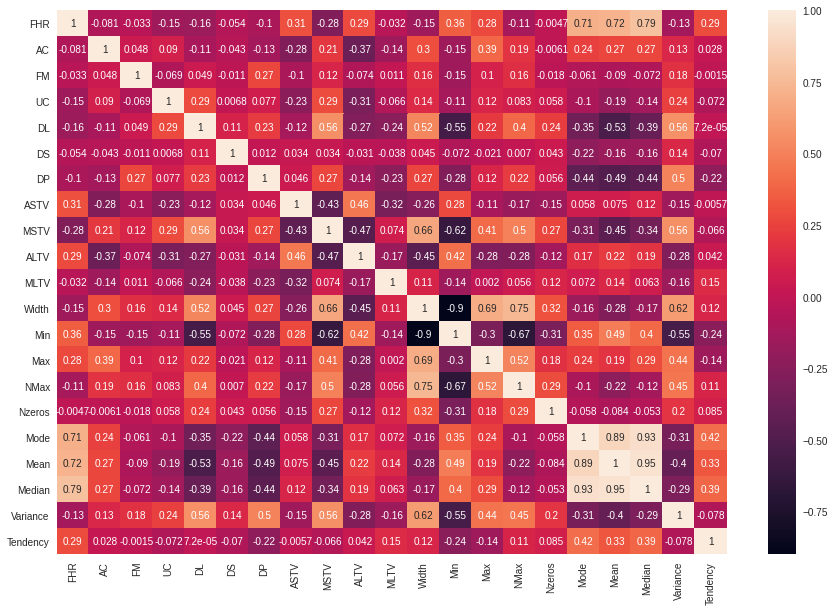

In [15]:
plt.figure(figsize=[15,10])
x=data.corr()
sb.heatmap(x,annot=True)

**Following variables has maximum correlations.**
* Min and width has -0.9 
* Min and NMax has -0.67 
* Min and MSTV has -0.62  
* Mode and Mean has 0.89 
* Mode and Median has 0.93 
* Mean and Median has 0.95

# **Visualization**

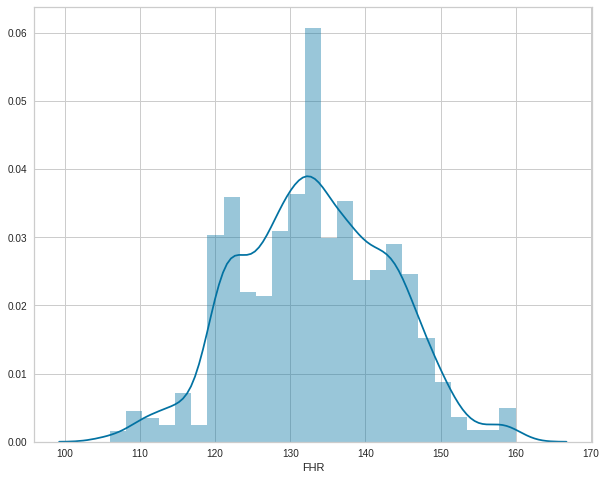

In [16]:
plt.figure(figsize = [10, 8])
sb.distplot(data['FHR'])

* distplots are great to know about the distribution of variable. 
* But if we have a classification prob with multiple classes and we would like to know about the distribution of single variable for different class violinplots helps alot.

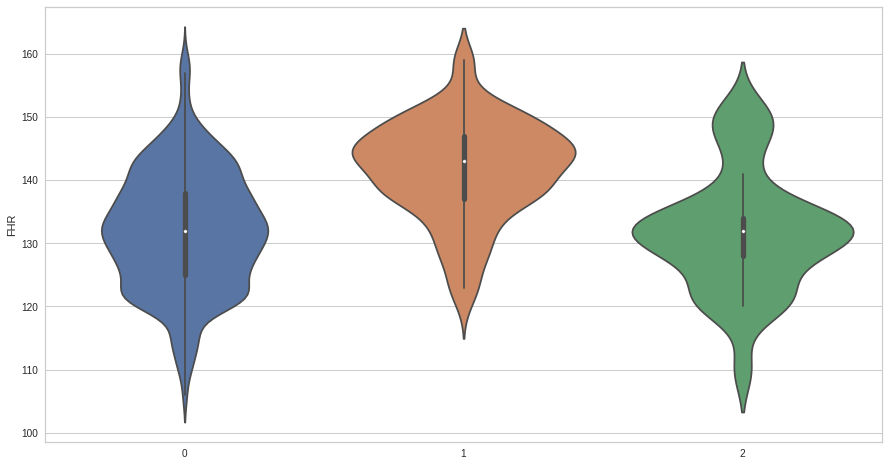

In [17]:
plt.figure(figsize=[15,8])
sb.violinplot(x=y_en, y=data.FHR, palette="deep")

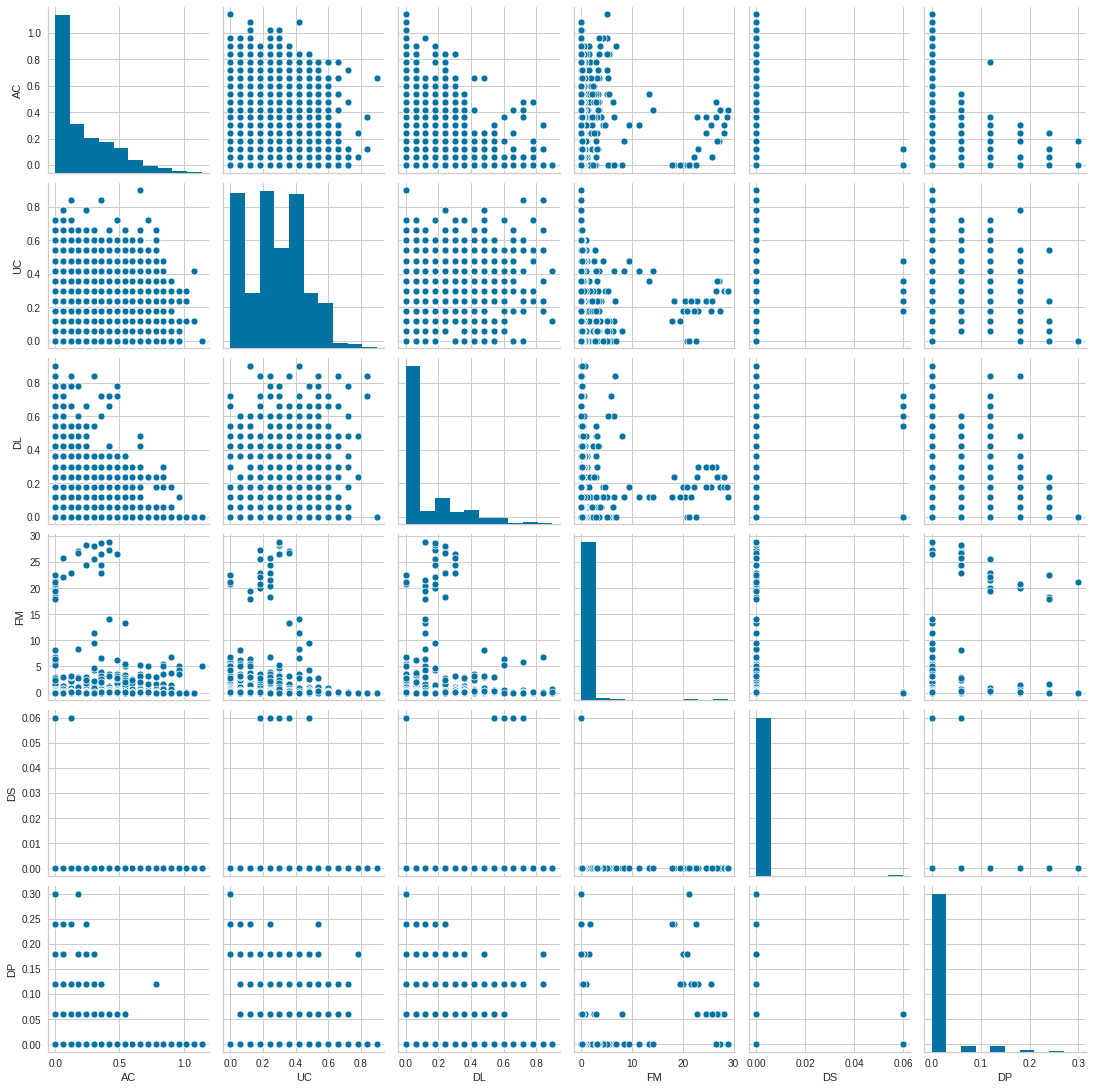

In [18]:
sb.pairplot(data[['AC', 'UC', 'DL', 'FM', 'DS', 'DP']])

Few graphs in plot are very sparse, becouse they have more Zero's. 

In [19]:
def zero_table(df):
    for column in df.columns:
        zero_count = (df[column] == 0).sum()
        if zero_count != 0:
            zero_percentage = 100*zero_count/len(df[column])
            if zero_percentage > 60:
                print("%s has %s Zeros" % (column, zero_count))
                print("Percentage of Zeros %0.1f%%" % (zero_percentage))
                print("-"*25)

In [20]:
zero_table(data)

FM has 1311 Zeros
Percentage of Zeros 61.7%
-------------------------
DS has 2119 Zeros
Percentage of Zeros 99.7%
-------------------------
DP has 1948 Zeros
Percentage of Zeros 91.6%
-------------------------
Nzeros has 1624 Zeros
Percentage of Zeros 76.4%
-------------------------


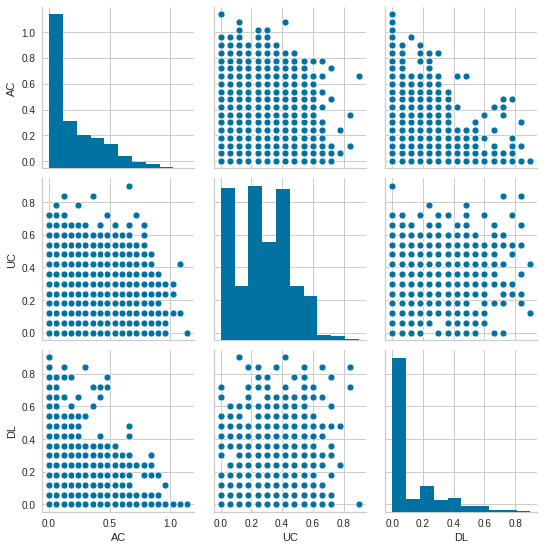

In [21]:
sb.pairplot(data[['AC', 'UC', 'DL']])

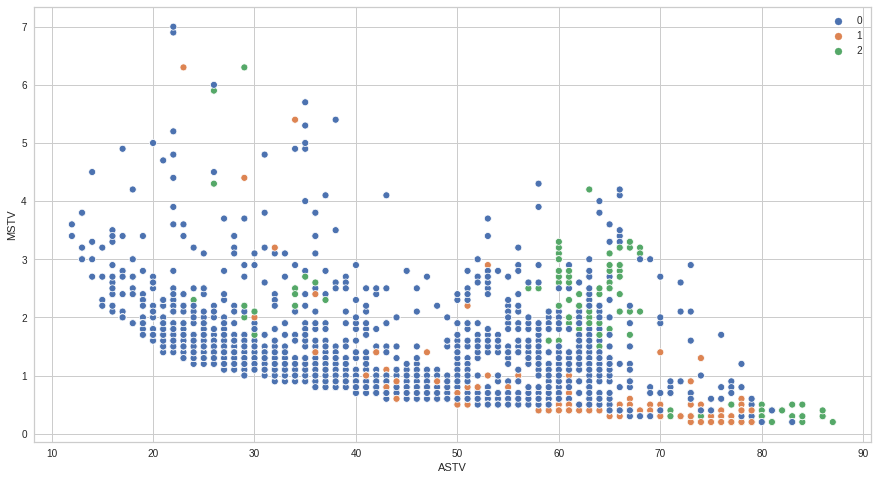

In [22]:
plt.figure(figsize=[15,8])
sb.scatterplot(x = data['ASTV'], y = data['MSTV'],
              hue = y_en, palette="deep")

* We can observe that Suspect and Pathologic cases are increasing as ASTV increase.
* Suspect and Pathologic cases are increasing as MSTV increasing by keeping ASTV constant.

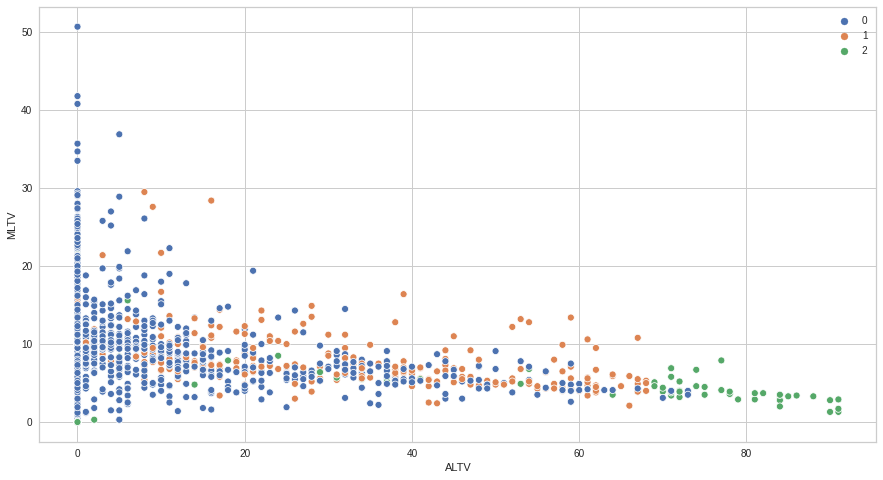

In [23]:
plt.figure(figsize=[15,8])
sb.scatterplot(x = data['ALTV'], y = data['MLTV'],
              hue = y_en, palette="deep")

* We can observe that Suspect and Pathologic cases are increasing as ALTV increase.

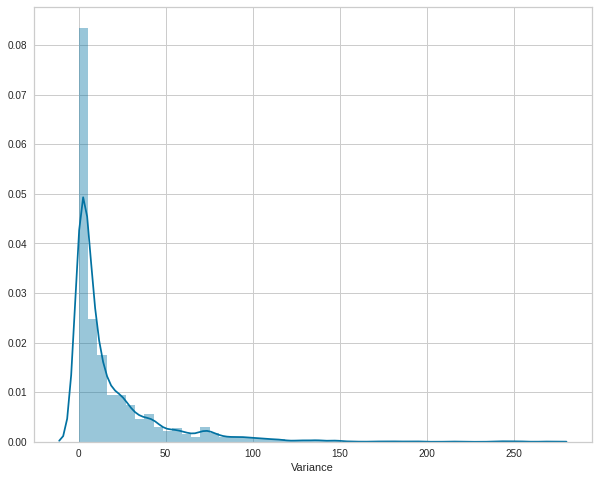

In [24]:
plt.figure(figsize = [10, 8])
sb.distplot(data['Variance'])

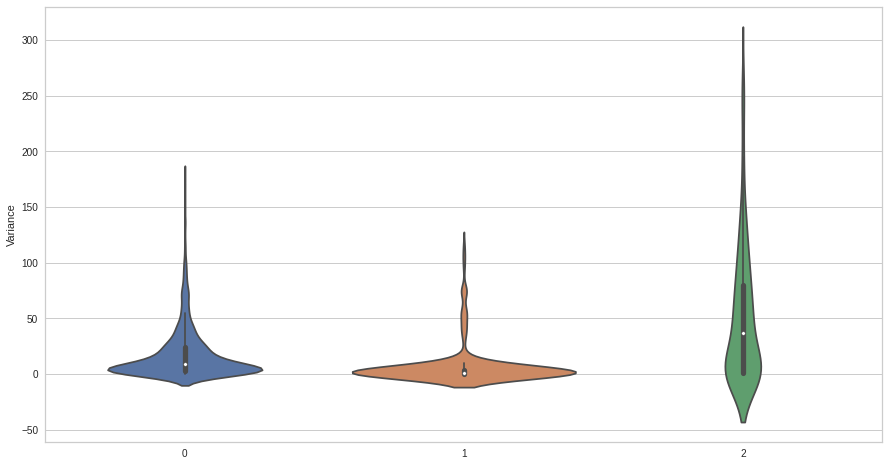

In [25]:
plt.figure(figsize=[15,8])
sb.violinplot(x=y_en, y=data.Variance, palette="deep")

* We can see that Normal clases have variance values concentrated more at Zero and slightly distrubuted for low values
* For Suspect cases the variance concentrated more at Zero and very low values at small varince values.
* For Pathologic case, the variance values are almost equally distributed among all the values.

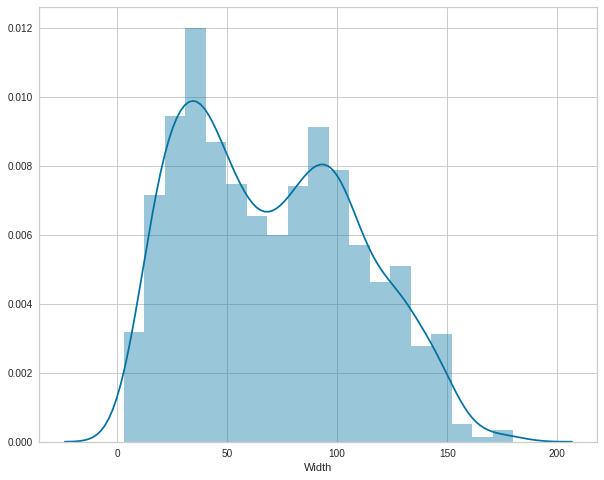

In [26]:
plt.figure(figsize = [10, 8])
sb.distplot(data['Width'])

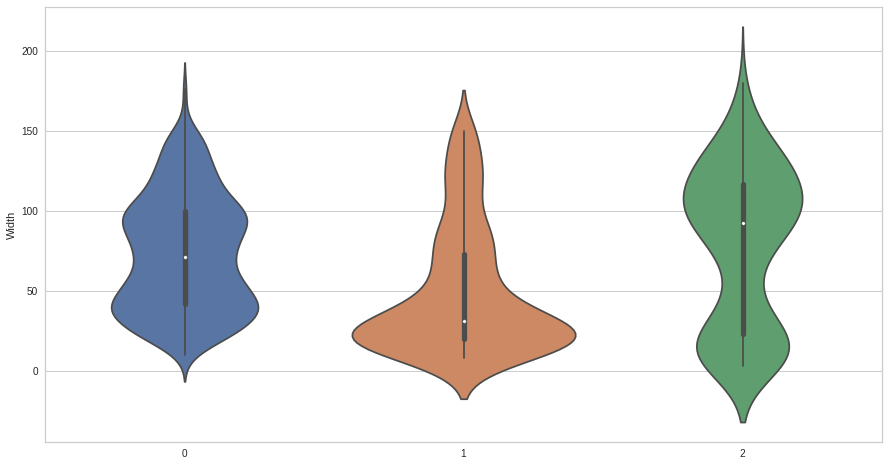

In [27]:
plt.figure(figsize=[15,8])
sb.violinplot(x=y_en, y=data.Width, palette="deep")

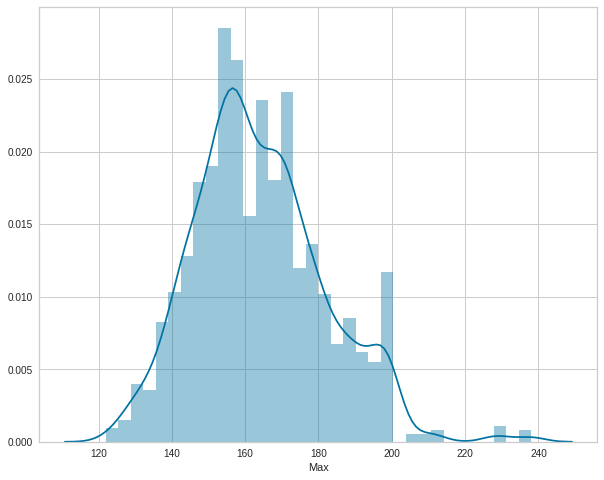

In [28]:
plt.figure(figsize = [10, 8])
sb.distplot(data['Max'])

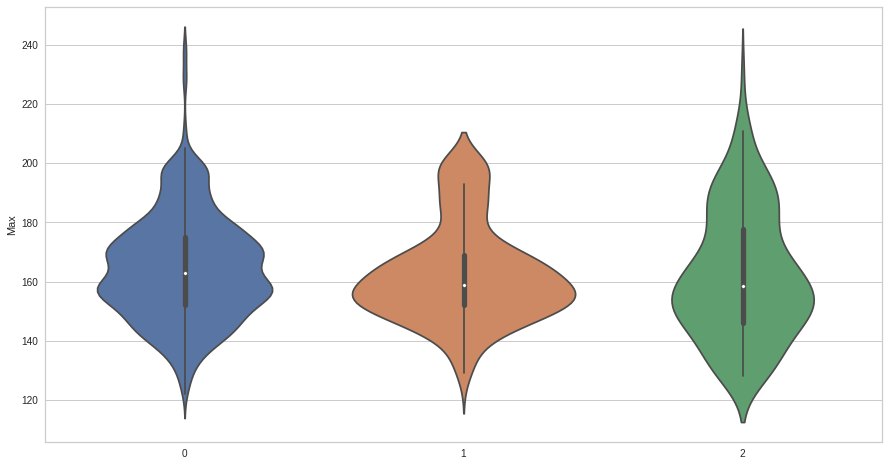

In [29]:
plt.figure(figsize=[15,8])
sb.violinplot(x=y_en, y=data.Max, palette="deep")

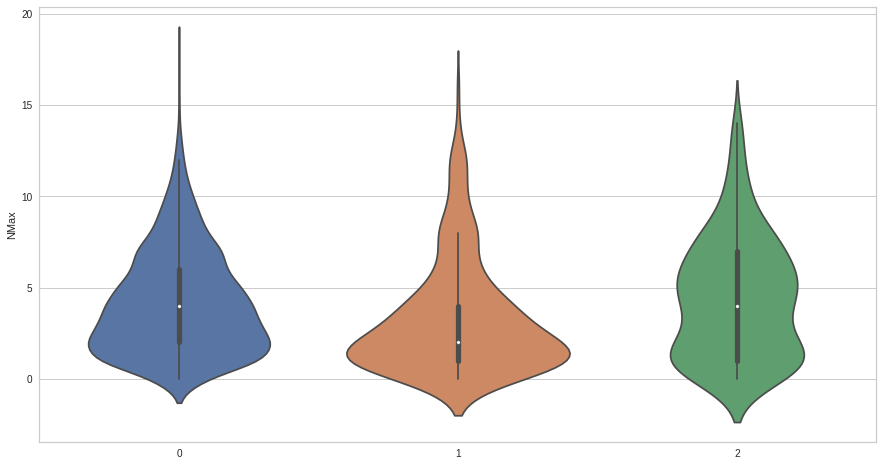

In [30]:
plt.figure(figsize=[15,8])
sb.violinplot(x=y_en, y=data.NMax, palette="deep")

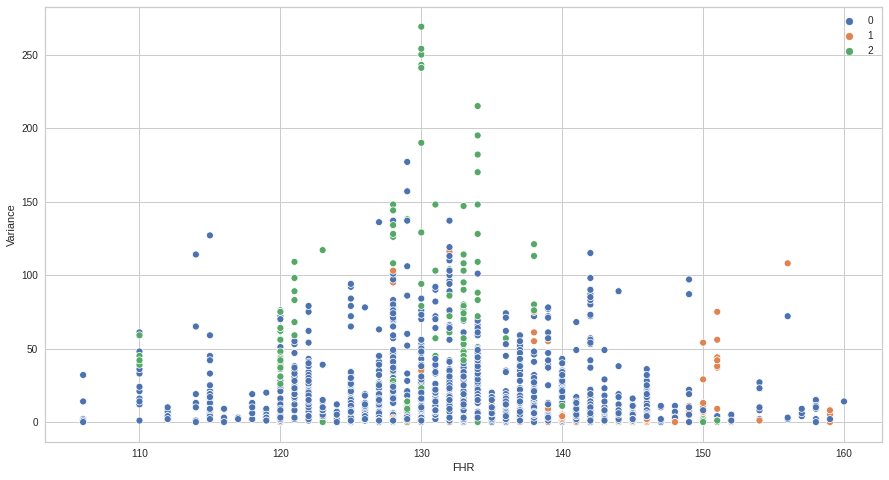

In [31]:
plt.figure(figsize=[15,8])
sb.scatterplot(x=data.FHR, y=data.Variance, hue=y_en, palette="deep")

* We can see that the most Pathologic cases are found at mean FHR and medium to high variance values.

# Model Fitting

In [32]:
def classifier_results(x, y):
    
    x_train,x_test,y_train,y_test = train_test_split(x, y, test_size=0.3)

    classifiers = {
        'L1 logistic': LogisticRegression(penalty = 'l2', solver = 'saga', 
                            multi_class = 'multinomial', max_iter = 10000),
        'L2 logistic (Multinomial)': LogisticRegression(penalty = 'l1', solver = 'saga', 
                             multi_class = 'multinomial', max_iter = 10000),
        'L2 logistic (OvR)': LogisticRegression(penalty='l2', solver='saga',
                       multi_class='ovr', max_iter=10000),
        'Linear SVC': SVC(kernel='linear', probability=True),

    }
    
    class_names = ['Normal', 'Suspect', 'Pathologic']

    for index, (name, classifier) in enumerate(classifiers.items()):
        classifier.fit(x_train, y_train)
        y_pred = classifier.predict(x_test)
        accuracy = accuracy_score(y_test, y_pred)
        print("Accuracy (test) for %s: %0.1f%% " % (name, accuracy * 100))
        print('-'*40)
        
        fig, ax = plt.subplots(figsize=(12, 7))
        visualizer = ClassificationReport(classifier, classes=class_names, support=True, ax=ax)
        visualizer.fit(x_train, y_train)       
        visualizer.score(x_test, y_test)       
        visualizer.show()
        
        fig, ax = plt.subplots(figsize=(12, 7))
        cm = ConfusionMatrix(classifier, classes = class_names, ax=ax)
        cm.fit(x_train, y_train)
        cm.score(x_test, y_test)
        cm.show()
        
        y_lb = label_binarize(y_en, classes=[0, 1, 2])
        n_classes = y_lb.shape[1]
        
        x2_train,x2_test,y2_train,y2_test = train_test_split(data, y_lb, test_size=0.3)

        estimator = OneVsRestClassifier(classifier)
        y2_dist = estimator.fit(x2_train, y2_train).decision_function(x2_test)
        y2_pred = estimator.predict(x2_test)
        
        fpr = dict()
        tpr = dict()
        roc_auc = dict()

        # Compute ROC curve and ROC area for each class
        for i in range(n_classes):
            fpr[i], tpr[i], _ = roc_curve(y2_test[:, i], y2_dist[:, i])
            roc_auc[i] = auc(fpr[i], tpr[i])

        # Compute micro-average ROC curve and ROC area
        fpr["micro"], tpr["micro"], _ = roc_curve(y2_test.ravel(), y2_dist.ravel())
        roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])
        
        all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

        # Then interpolate all ROC curves at this points
        mean_tpr = np.zeros_like(all_fpr)
        for i in range(n_classes):
            mean_tpr += interp(all_fpr, fpr[i], tpr[i])

        # Finally average it and compute AUC
        mean_tpr /= n_classes

        fpr["macro"] = all_fpr
        tpr["macro"] = mean_tpr
        roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

        # Plot all ROC curves
        plt.figure(figsize=[15,7])
        plt.plot(fpr["micro"], tpr["micro"],
                 label='micro-average ROC curve (area = {0:0.2f})'
                       ''.format(roc_auc["micro"]),
                 color='deeppink', linestyle=':', linewidth=4)

        plt.plot(fpr["macro"], tpr["macro"],
                 label='macro-average ROC curve (area = {0:0.2f})'
                       ''.format(roc_auc["macro"]),
                 color='navy', linestyle=':', linewidth=4)

        colors = cycle(['aqua', 'darkorange', 'cornflowerblue'])
        for i, color in zip(range(n_classes), colors):
            plt.plot(fpr[i], tpr[i], color=color, lw=2,
                     label='ROC curve of class {0} (area = {1:0.2f})'
                     ''.format(i+1, roc_auc[i]))

        plt.plot([0, 1], [0, 1], 'k--', lw=2)
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.05])
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title('Some extension of Receiver operating characteristic to multi-class')
        plt.legend(loc="lower right")
        plt.show()

Accuracy (test) for L1 logistic: 87.5% 
----------------------------------------


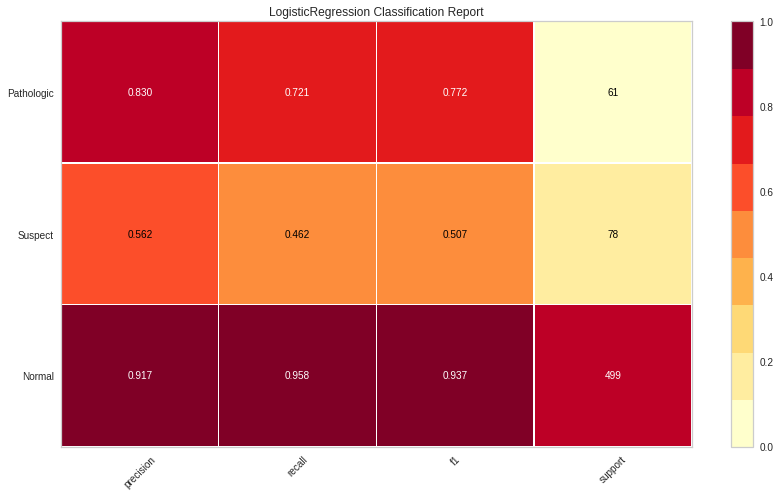

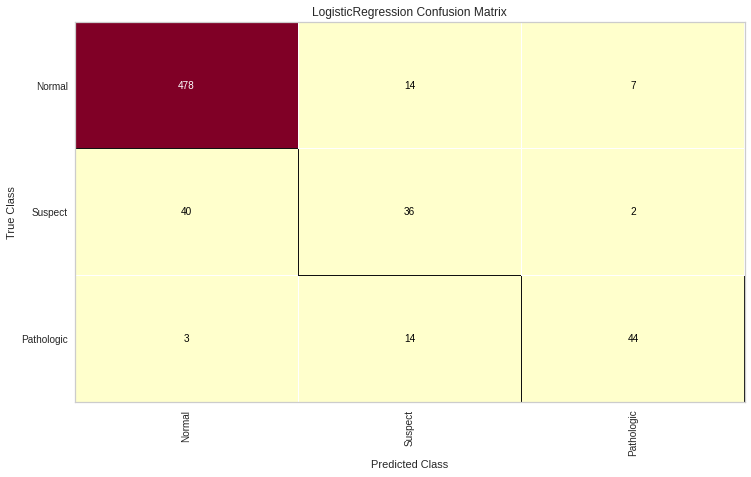

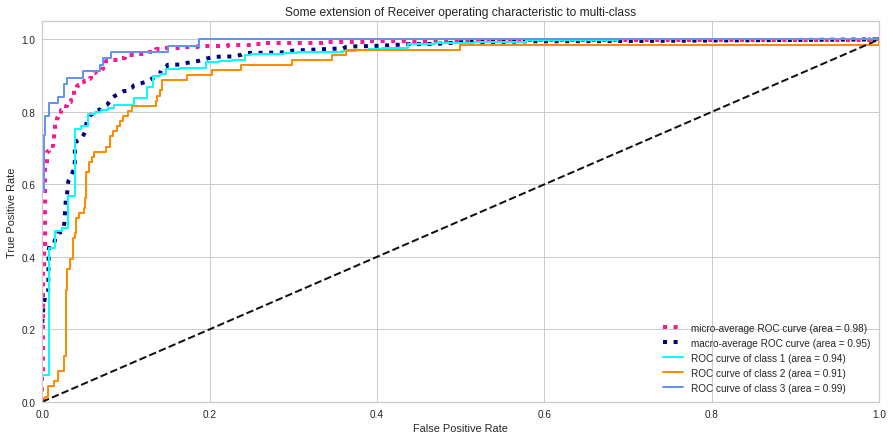

Accuracy (test) for L2 logistic (Multinomial): 87.0% 
----------------------------------------


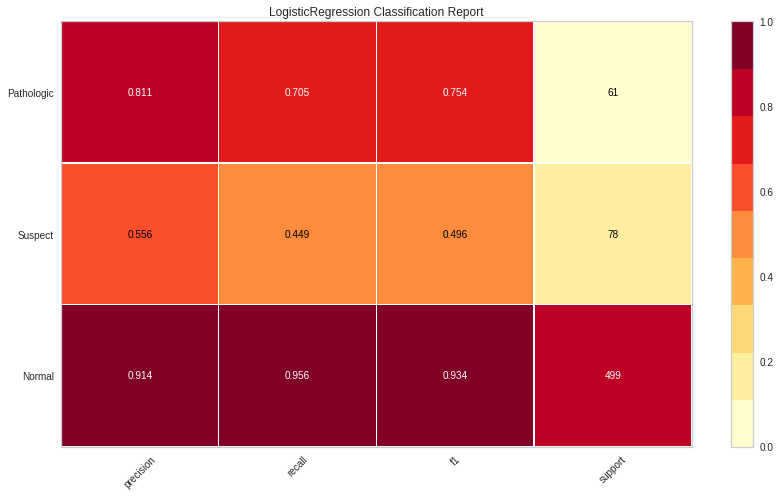

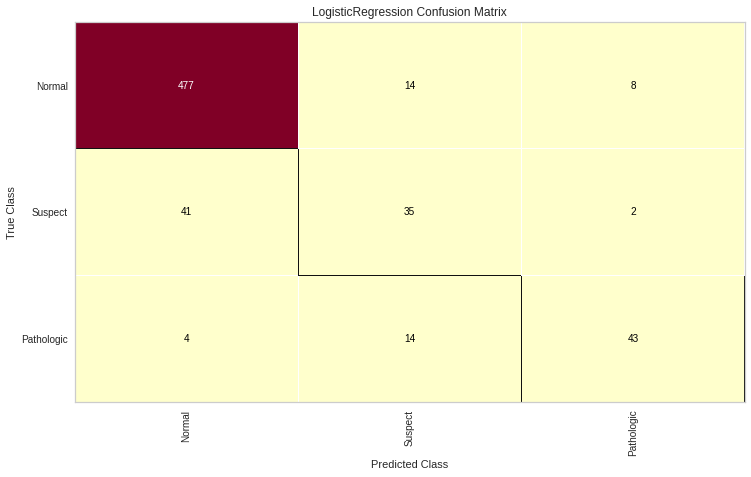

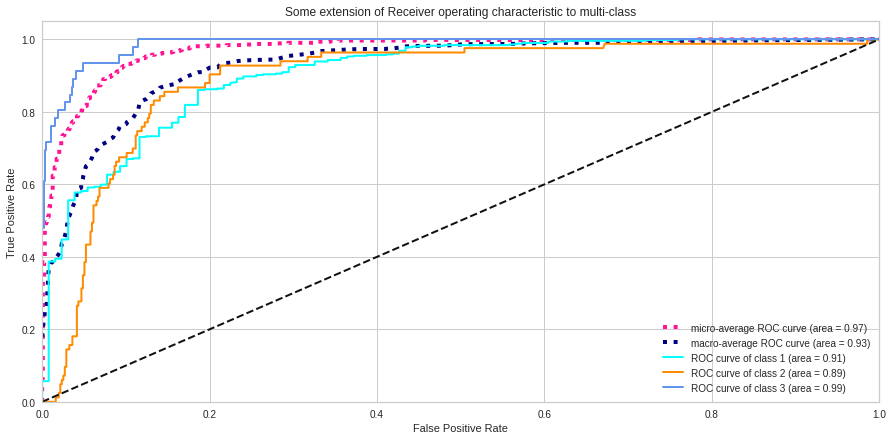

Accuracy (test) for L2 logistic (OvR): 86.2% 
----------------------------------------


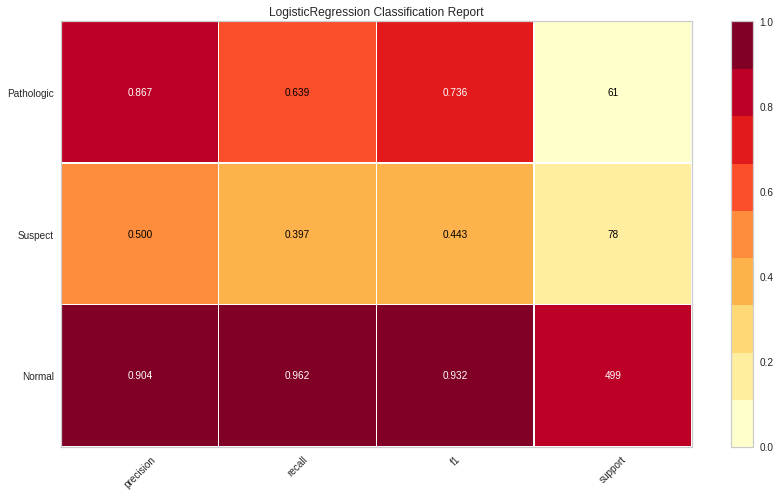

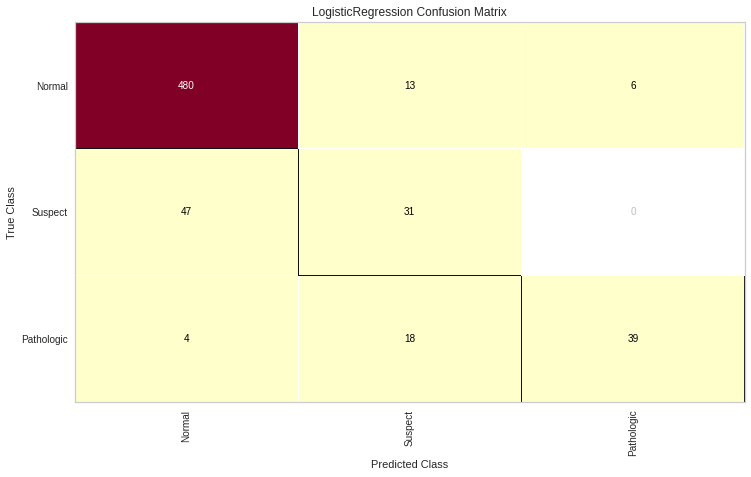

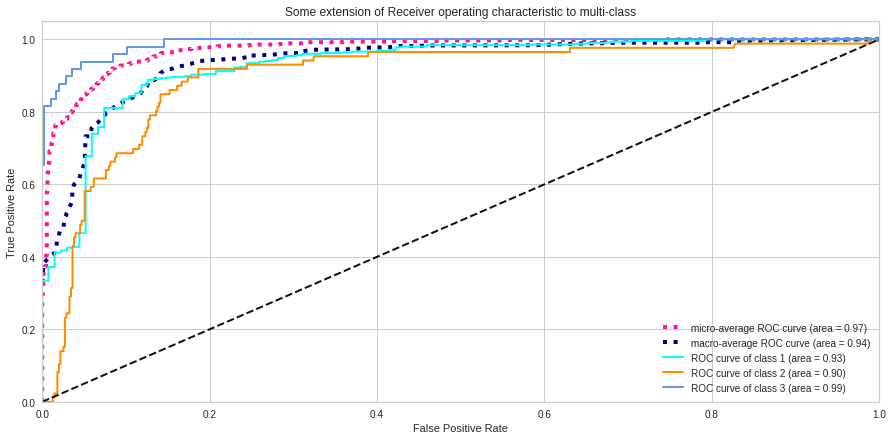

Accuracy (test) for Linear SVC: 88.2% 
----------------------------------------


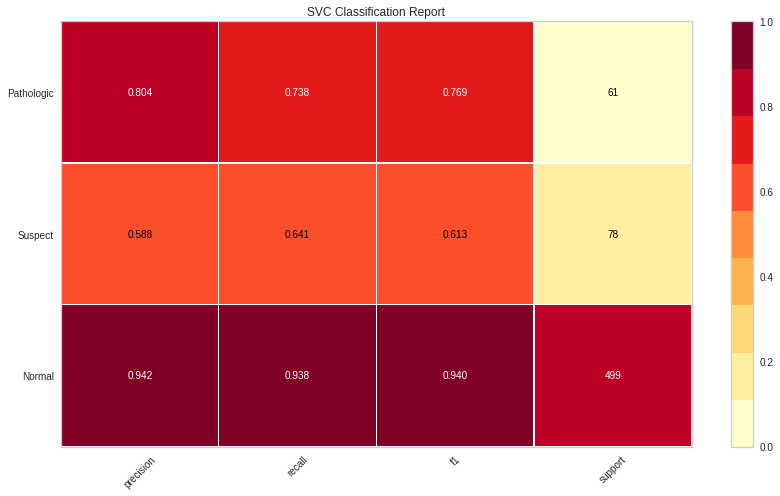

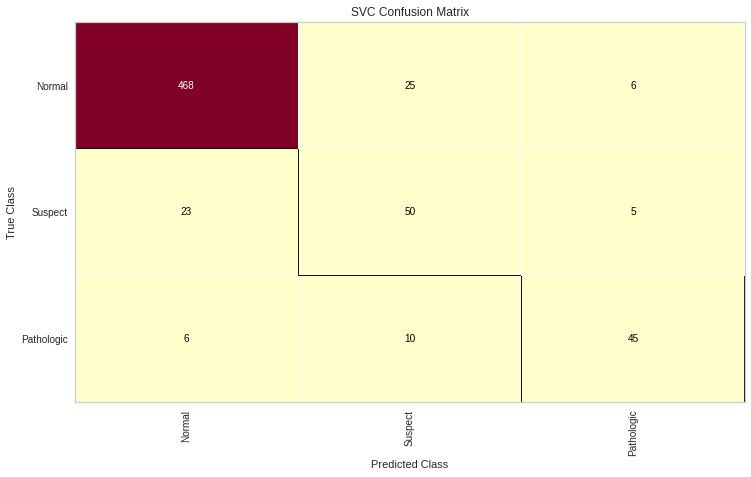

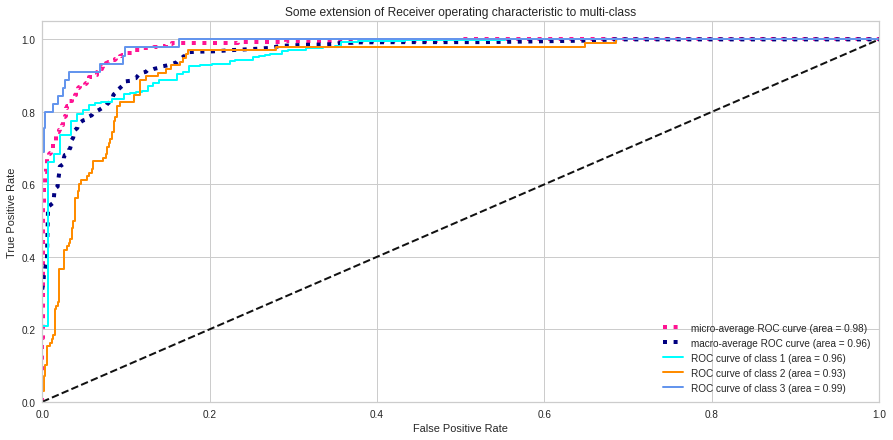

In [33]:
classifier_results(data, y_en)

In [34]:
def RF_AdB_GNB_classifier_results(x, y):
    
    x_train,x_test,y_train,y_test = train_test_split(x, y, test_size=0.3)

    classifiers = {
        'RandomForest': RandomForestClassifier(),
        'AdaBoost': AdaBoostClassifier(),
        'GaussianNB': GaussianNB()

    }
    
    class_names = ['Normal', 'Suspect', 'Pathologic']

    for index, (name, classifier) in enumerate(classifiers.items()):
        classifier.fit(x_train, y_train)
        y_pred = classifier.predict(x_test)
        accuracy = accuracy_score(y_test, y_pred)
        print("Accuracy (test) for %s: %0.1f%% " % (name, accuracy * 100))
        print('-'*40)
        
        fig, ax = plt.subplots(figsize=(12, 7))
        visualizer = ClassificationReport(classifier, classes=class_names, support=True, ax=ax)
        visualizer.fit(x_train, y_train)        # Fit the visualizer and the model
        visualizer.score(x_test, y_test)        # Evaluate the model on the test data
        visualizer.show()
        
        fig, ax = plt.subplots(figsize=(12, 7))
        cm = ConfusionMatrix(classifier, classes = class_names, ax=ax)
        cm.fit(x_train, y_train)
        cm.score(x_test, y_test)
        cm.show()

        fig, ax = plt.subplots(figsize=(12, 7))
        roc = ROCAUC(classifier, classes=class_names, ax=ax)
        roc.fit(x_train, y_train)        # Fit the training data to the visualizer
        roc.score(x_test, y_test)        # Evaluate the model on the test data
        roc.show()
        
        fig, ax = plt.subplots(figsize=(12, 7))
        prc = PrecisionRecallCurve(classifier,
                                   classes=class_names,
                                   colors=["purple", "cyan", "blue"],
                                   iso_f1_curves=True,
                                   per_class=True,
                                   micro=False, ax=ax)
        prc.fit(x_train, y_train)
        prc.score(x_test, y_test)
        prc.show()

Accuracy (test) for RandomForest: 94.2% 
----------------------------------------


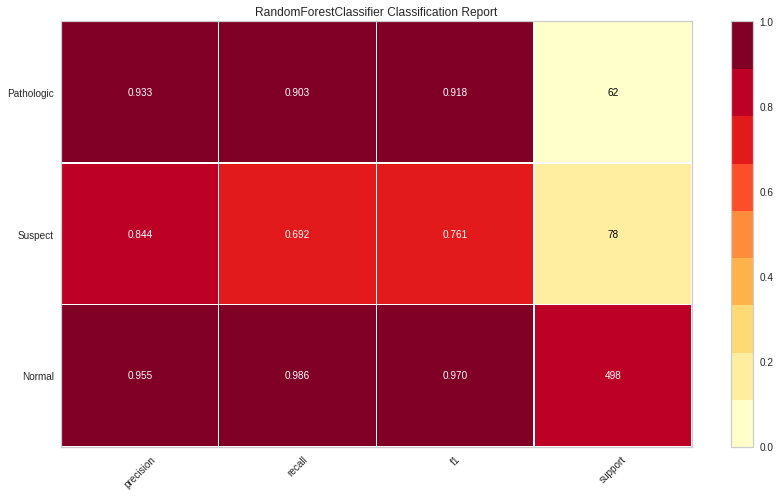

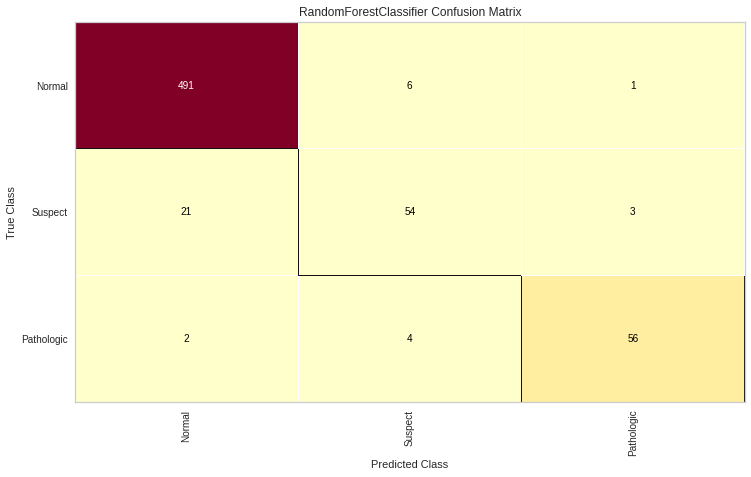

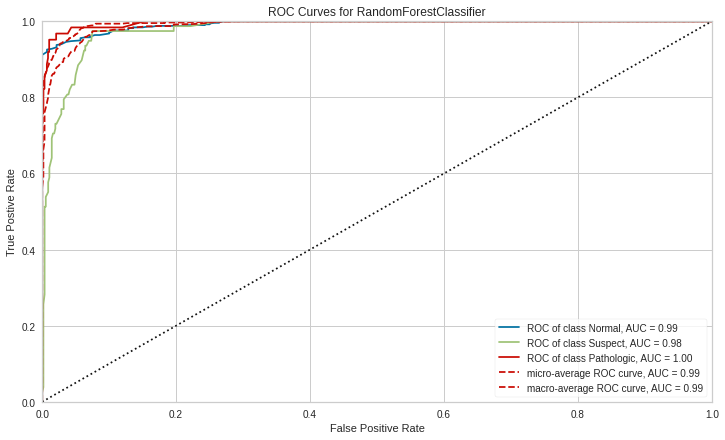

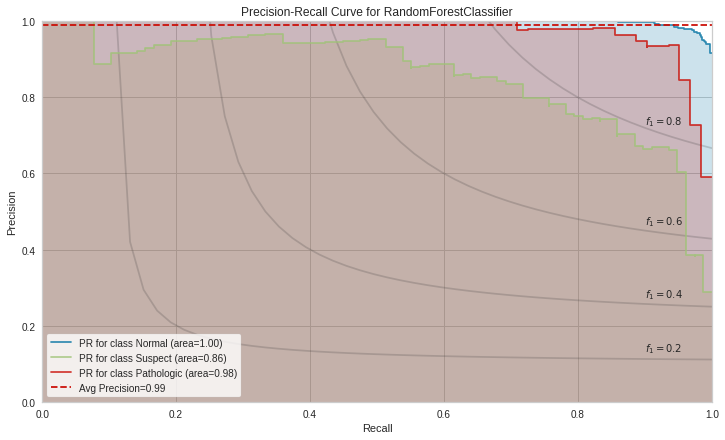

Accuracy (test) for AdaBoost: 88.1% 
----------------------------------------


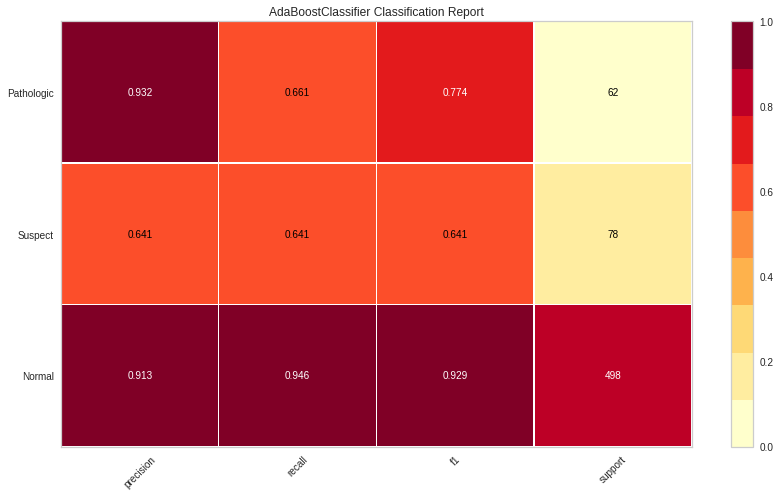

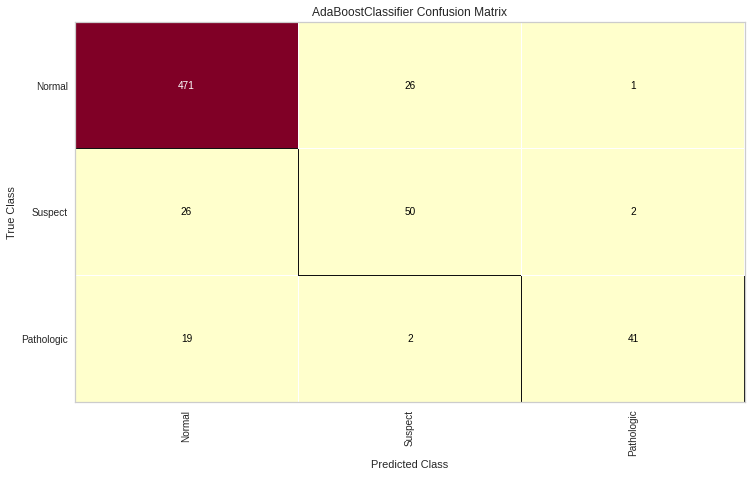

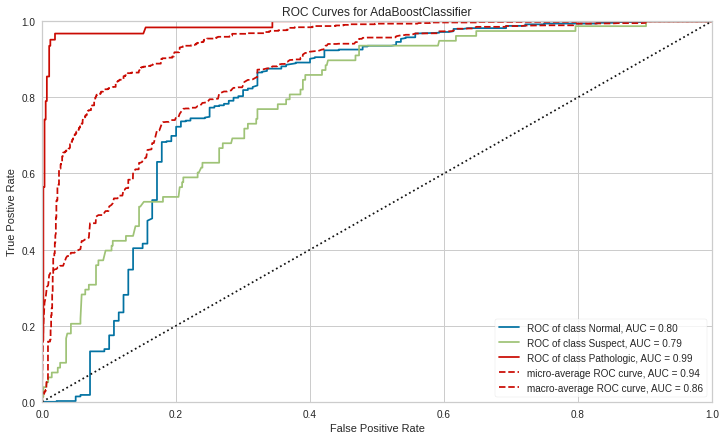

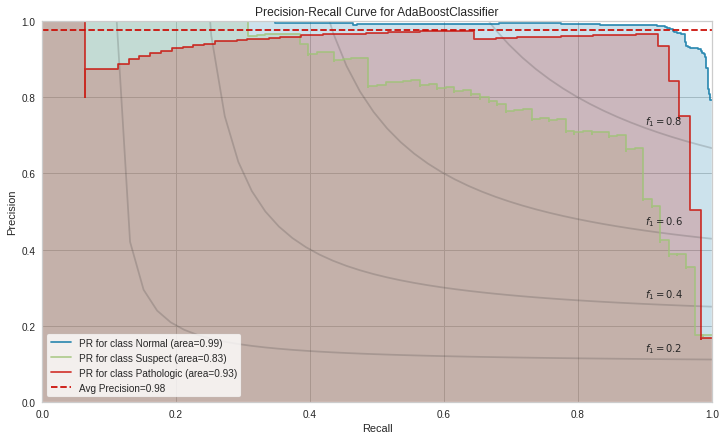

Accuracy (test) for GaussianNB: 83.2% 
----------------------------------------


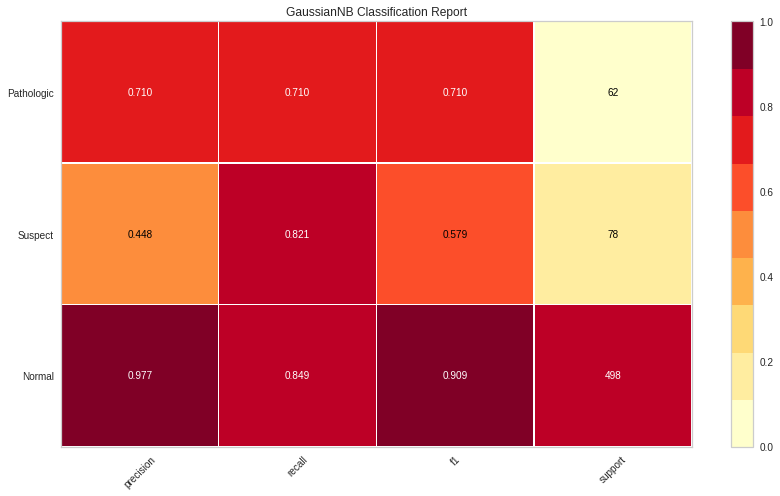

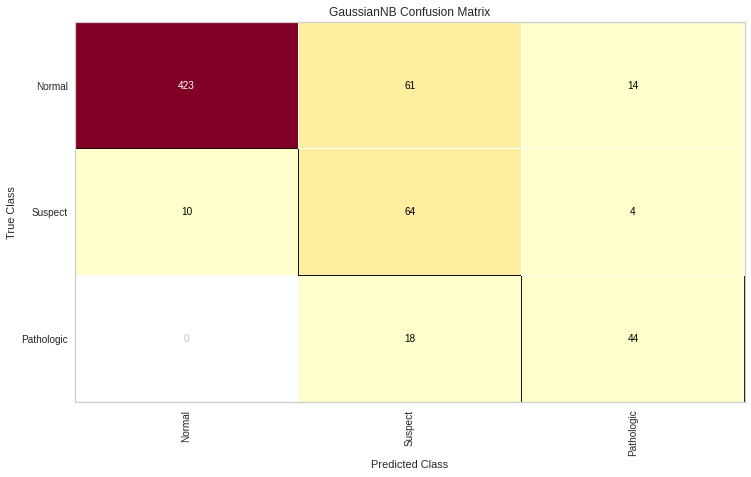

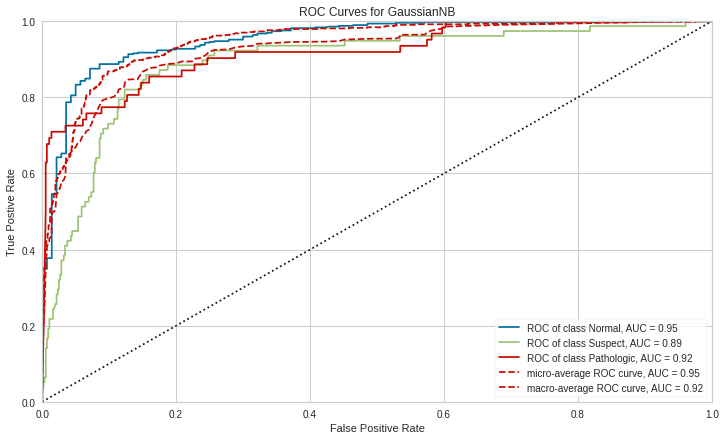

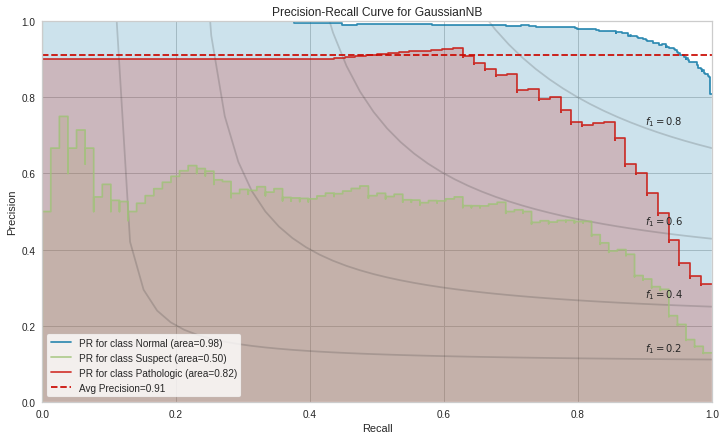

In [35]:
RF_AdB_GNB_classifier_results(data, y_en)

## ***Observed that Random Forest Classifer did best of all the classifiers.***

## **Please Upvote if you find this notebook useful**